<a href="https://colab.research.google.com/github/DKuzn/Recognition-RusHandRilNet/blob/master/MNIST_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import matplotlib.pyplot as plt

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [ ]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

model = MyModel()

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [ ]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [ ]:
loss_train = []
loss_test = []
accuracy_train = []
accuracy_test = []

EPOCHS = 20

with tf.device('/GPU:0'):
    for epoch in range(EPOCHS):
        for images, labels in train_ds:
            train_step(images, labels)

        for test_images, test_labels in test_ds:
            test_step(test_images, test_labels)

        template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
        print (template.format(epoch+1,
                                train_loss.result(),
                                train_accuracy.result()*100,
                                test_loss.result(),
                                test_accuracy.result()*100))
        loss_train.append(train_loss.result())
        loss_test.append(test_loss.result())
        accuracy_train.append(train_accuracy.result())
        accuracy_test.append(test_accuracy.result())

Epoch 1, Loss: 0.013226071372628212, Accuracy: 99.58881378173828, Test Loss: 0.08376575261354446, Test Accuracy: 98.39380645751953
Epoch 2, Loss: 0.012721343897283077, Accuracy: 99.60462188720703, Test Loss: 0.08512536436319351, Test Accuracy: 98.40045928955078
Epoch 3, Loss: 0.012226644903421402, Accuracy: 99.61956787109375, Test Loss: 0.08624927699565887, Test Accuracy: 98.40739440917969
Epoch 4, Loss: 0.011826388537883759, Accuracy: 99.632568359375, Test Loss: 0.08803848177194595, Test Accuracy: 98.40625
Epoch 5, Loss: 0.011430232785642147, Accuracy: 99.64500427246094, Test Loss: 0.08929728716611862, Test Accuracy: 98.40999603271484
Epoch 6, Loss: 0.011043770238757133, Accuracy: 99.65699005126953, Test Loss: 0.09038880467414856, Test Accuracy: 98.40846252441406
Epoch 7, Loss: 0.010724732652306557, Accuracy: 99.66747283935547, Test Loss: 0.09170770645141602, Test Accuracy: 98.40184783935547
Epoch 8, Loss: 0.010354136116802692, Accuracy: 99.67898559570312, Test Loss: 0.092231534421443

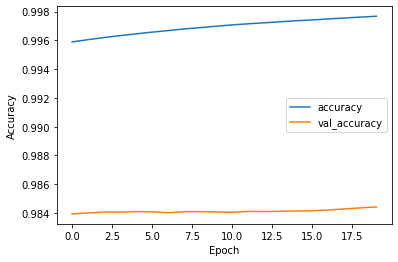

In [ ]:
plt.plot(accuracy_train, label='accuracy')
plt.plot(accuracy_test, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='right')

In [ ]:
#loss_train.clear()
#loss_test.clear()
#accuracy_train.clear()
#accuracy_test.clear()

In [ ]:
print(loss_train[0])

tf.Tensor(0.013226071, shape=(), dtype=float32)
